# Temporal GCN (EvolveGCN-style)

**Objective**: Temporal GNN that processes graph sequences over time.

**Key principle**: Per-cohort training with state reset. Each cohort C_t gets K+1 graphs.

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_temporal_model_graphs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm.notebook import tqdm

torch.manual_seed(42)
np.random.seed(42)

## Configuration

In [2]:
from test_config import EXPERIMENT_CONFIG

CONFIG = EXPERIMENT_CONFIG.copy()
# Temporal GNN specific settings (FIXED for class imbalance)
CONFIG['dropout'] = 0.3  # Reduced from default to prevent over-regularization
CONFIG['learning_rate'] = 0.001  # Use same as test_config
CONFIG['weight_decay'] = 1e-5  # Reduced to allow model to fit minority class
CONFIG['epochs'] = 100  # Increased from 50 for better convergence
CONFIG['patience'] = 30  

print(f"Device: {CONFIG['device']}")
print(f"Observation windows: {CONFIG['observation_windows']}")

Device: cuda
Observation windows: [1, 3, 5]


## Load Data & Create Splits

In [3]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance_features(nodes_df, threshold=0.01, verbose=True):
    """Remove features with variance below threshold."""
    exclude_cols = {'address', 'Time step', 'class'}
    feature_cols = [col for col in nodes_df.columns 
                    if col not in exclude_cols and 
                    pd.api.types.is_numeric_dtype(nodes_df[col])]
    
    # Sample for speed
    sample_df = nodes_df[feature_cols].sample(n=min(10000, len(nodes_df)), random_state=42)
    
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(sample_df)
    
    kept_features = [col for col, keep in zip(feature_cols, selector.get_support()) if keep]
    
    if verbose:
        print(f"Removed {len(feature_cols) - len(kept_features)} low-variance features")
        print(f"Kept {len(kept_features)} features")
    
    return kept_features

def remove_correlated_features(nodes_df, threshold=0.95, verbose=True):
    """
    Remove highly correlated features from nodes DataFrame.
    
    Args:
        nodes_df: DataFrame with node features
        threshold: Correlation threshold (default 0.95)
        verbose: Print removed features
    
    Returns:
        nodes_df with correlated features removed
        list of kept feature columns
    """
    # Identify feature columns (exclude address, Time step, class)
    exclude_cols = {'address', 'Time step', 'class'}
    feature_cols = [col for col in nodes_df.columns 
                    if col not in exclude_cols and 
                    pd.api.types.is_numeric_dtype(nodes_df[col])]
    
    # Compute correlation matrix on a sample (for speed)
    sample_size = min(10000, len(nodes_df))
    sample_df = nodes_df[feature_cols].sample(n=sample_size, random_state=42)
    corr_matrix = sample_df.corr().abs()
    
    # Find features to remove
    upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    to_remove = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # Remove the second feature (arbitrary choice)
                feature_to_remove = corr_matrix.columns[j]
                to_remove.add(feature_to_remove)
                if verbose:
                    print(f"Removing {feature_to_remove} (corr={corr_matrix.iloc[i, j]:.3f} with {corr_matrix.columns[i]})")
    
    # Keep features
    features_to_keep = [col for col in feature_cols if col not in to_remove]
    
    if verbose:
        print(f"\nOriginal features: {len(feature_cols)}")
        print(f"Removed features:  {len(to_remove)}")
        print(f"Kept features:     {len(features_to_keep)}")
    
    return features_to_keep

In [4]:
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)
kept_features = remove_correlated_features(nodes_df, threshold=0.95, verbose=True)

Removing out_num (corr=0.979 with in_num)
Removing in_fees_sum (corr=1.000 with in_total_fees)
Removing in_median_fees (corr=0.999 with in_mean_fees)
Removing in_fees_mean (corr=1.000 with in_mean_fees)
Removing in_fees_median (corr=0.999 with in_mean_fees)
Removing in_fees_mean (corr=0.999 with in_median_fees)
Removing in_fees_median (corr=1.000 with in_median_fees)
Removing in_total_BTC_sum (corr=1.000 with in_total_btc_in)
Removing in_in_BTC_max_sum (corr=0.978 with in_total_btc_in)
Removing in_in_BTC_total_sum (corr=1.000 with in_total_btc_in)
Removing in_out_BTC_max_sum (corr=0.982 with in_total_btc_in)
Removing in_out_BTC_total_sum (corr=1.000 with in_total_btc_in)
Removing in_median_btc_in (corr=0.997 with in_mean_btc_in)
Removing in_total_BTC_mean (corr=1.000 with in_mean_btc_in)
Removing in_total_BTC_median (corr=0.997 with in_mean_btc_in)
Removing in_in_BTC_min_mean (corr=0.982 with in_mean_btc_in)
Removing in_in_BTC_min_median (corr=0.978 with in_mean_btc_in)
Removing in_in_

In [11]:
builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    feature_cols=kept_features,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../../graph_cache_reduced_features',
    use_cache=True,
    verbose=True
)

split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

print(f"\nTrain: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")

Created cache directory: ../../graph_cache_reduced_features
  Pre-processing node features by (address, timestep)...
  Pre-processing edges by timestep...
  Average new nodes per timestep: 16794.7
Initialized TemporalNodeClassificationBuilder
  Total nodes: 822942
  Total edges: 2868964
  Time steps: 1 to 49
  Feature columns (36): ['in_num', 'in_total_fees', 'in_mean_fees', 'in_total_btc_in', 'in_mean_btc_in']...
  Include class as feature: False
  Add temporal features: True
  Add edge weights: False

Temporal Split Summary:
  Train: timesteps 5-24, 96470 nodes
    Illicit: 4888, Licit: 91582
Training illicit ratio: 0.050668601637814864
  Val:   timesteps 29-31, 9884 nodes
    Illicit: 664, Licit: 9220
Validation illicit ratio: 0.06717927964386888
  Test:  timesteps 37-43, 39305 nodes
    Illicit: 1849, Licit: 37456
Test illicit ratio: 0.04704236102277064

Train: 96470 nodes
Val:   9884 nodes
Test:  39305 nodes


## Prepare Per-Cohort Temporal Sequences

Each cohort C_t gets its own sequence of K+1 graphs.

In [12]:
device = torch.device(CONFIG['device'])

sequences = prepare_temporal_model_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=device
)


PREPARING PER-COHORT TEMPORAL SEQUENCES

Split boundaries:
  Train: t=5 to t=24
  Val:   t=29 to t=31
  Test:  t=37 to t=43

Observation windows: K = [1, 3, 5]

K = 1 (Per-cohort sequences of 2 graphs)

TRAIN split:
  Processing 20 cohorts (t=5 to t=24)
  💾 Cached graph to ../../graph_cache_reduced_features/graph_t5_metaTrue_classFalse_tempTrue_weightsFalse.pt
  💾 Cached graph to ../../graph_cache_reduced_features/graph_t6_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features/graph_t6_metaTrue_classFalse_tempTrue_weightsFalse.pt
  💾 Cached graph to ../../graph_cache_reduced_features/graph_t7_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features/graph_t7_metaTrue_classFalse_tempTrue_weightsFalse.pt
  💾 Cached graph to ../../graph_cache_reduced_features/graph_t8_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features/graph_t8_

## Temporal GCN Model with State Reset

In [13]:
class TemporalGCN(nn.Module):
    """Temporal GCN with LSTM and state reset capability."""
    
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNConv(num_features, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = dropout
        self.hidden_dim = hidden_dim
        self.h = None
        self.c = None
        
    def reset_state(self):
        """Reset LSTM hidden state between cohorts."""
        self.h = None
        self.c = None
    
    def forward_one_step(self, x, edge_index):
        # GCN layers
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn2(x, edge_index)
        
        # Aggregate to graph-level representation
        graph_emb = x.mean(dim=0, keepdim=True).unsqueeze(1)
        
        # LSTM update - NO DETACH
        if self.h is None:
            output, (self.h, self.c) = self.lstm(graph_emb)
        else:
            output, (self.h, self.c) = self.lstm(graph_emb, (self.h, self.c))  # ← No .detach()
        
        # Broadcast LSTM output back to nodes
        lstm_out = output.squeeze(1).expand(x.shape[0], -1)
        combined = x + lstm_out
        
        return combined
    
    def classify(self, embeddings):
        """Classify nodes from final embeddings."""
        return self.classifier(embeddings)

## Training Functions (Per-Cohort)

In [14]:
def train_epoch_per_cohort(model, cohorts, optimizer, criterion):
    """Train on all cohorts, resetting state between each."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for cohort in cohorts:
        model.reset_state()
        optimizer.zero_grad()
        
        # Feed sequence of K+1 graphs
        embeddings = None
        for graph in cohort['graphs']:
            embeddings = model.forward_one_step(graph.x, graph.edge_index)
        
        # Classify using final embeddings
        logits = model.classify(embeddings)
        
        # Loss only on this cohort's nodes
        cohort_indices = cohort['eval_indices']
        final_graph = cohort['graphs'][-1]
        
        loss = criterion(logits[cohort_indices], final_graph.y[cohort_indices])
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * len(cohort_indices)
        pred = logits[cohort_indices].argmax(dim=1)
        total_correct += (pred == final_graph.y[cohort_indices]).sum().item()
        total_samples += len(cohort_indices)
    
    return total_loss / total_samples, total_correct / total_samples


def evaluate_per_cohort(model, cohorts):
    """Evaluate on all cohorts, resetting state between each."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for cohort in cohorts:
            # CRITICAL: Reset state for each cohort
            model.reset_state()
            
            # Feed sequence
            embeddings = None
            for graph in cohort['graphs']:
                embeddings = model.forward_one_step(graph.x, graph.edge_index)
            
            # Classify
            logits = model.classify(embeddings)
            
            # Extract predictions for this cohort
            cohort_indices = cohort['eval_indices']
            final_graph = cohort['graphs'][-1]
            
            pred = logits[cohort_indices].argmax(dim=1).cpu().numpy()
            true = final_graph.y[cohort_indices].cpu().numpy()
            probs = F.softmax(logits[cohort_indices], dim=1)[:, 1].cpu().numpy()
            
            all_preds.append(pred)
            all_labels.append(true)
            all_probs.append(probs)
    
    # Concatenate all cohort predictions
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

## Train Models (Per-K Retraining)

In [15]:
results = {}
models = {}

for K in CONFIG['observation_windows']:
    print(f"\n{'='*70}")
    print(f"Training with K={K}")
    print('='*70)
    
    train_cohorts = sequences[K]['train']['cohorts']
    val_cohorts = sequences[K]['val']['cohorts']
    test_cohorts = sequences[K]['test']['cohorts']
    
    print(f"Train cohorts: {len(train_cohorts)}")
    print(f"Val cohorts:   {len(val_cohorts)}")
    print(f"Test cohorts:  {len(test_cohorts)}")
    print(f"Graphs per cohort: {K+1}")
    
    # Initialize model
    num_features = train_cohorts[0]['graphs'][0].x.shape[1]
    model = TemporalGCN(
        num_features=num_features,
        hidden_dim=CONFIG['hidden_dim'],
        num_classes=2,
        dropout=CONFIG['dropout']
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Compute class weights from all training cohorts
    all_train_labels = []
    for cohort in train_cohorts:
        final_graph = cohort['graphs'][-1]
        cohort_labels = final_graph.y[cohort['eval_indices']].cpu()
        all_train_labels.append(cohort_labels)
    all_train_labels = torch.cat(all_train_labels).long()
    
    class_counts = torch.bincount(all_train_labels)
    
    # More aggressive weighting: use sqrt of inverse frequency
    class_weights = torch.sqrt(1.0 / class_counts.float())
    class_weights = class_weights / class_weights.sum() * 2.0  # Normalize
    class_weights = class_weights.to(device)
    
    print(f"Class distribution: {class_counts.tolist()}")
    print(f"Class weights: {class_weights.tolist()}")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Training loop
    best_val_f1 = 0
    patience_counter = 0
    best_model_state = None
    best_epoch = 0
    
    pbar = tqdm(range(CONFIG['epochs']), desc=f"K={K}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch_per_cohort(
            model, train_cohorts, optimizer, criterion
        )
        
        # if (epoch + 1) % 2 == 0 or epoch == 0:
        val_metrics = evaluate_per_cohort(model, val_cohorts)
        train_metrics = evaluate_per_cohort(model, train_cohorts)
        pbar.set_postfix({
            'loss': f"{train_loss:.4f}",
            'train_f1': f"{train_metrics['f1']:.4f}",
            'val_f1': f"{val_metrics['f1']:.4f}"
        })
        
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= CONFIG['patience']:
            print(f"Early stopping at epoch {epoch+1} (best was epoch {best_epoch+1})")
            break
    
    # Load best model and evaluate
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model from epoch {best_epoch+1}")
    
    train_metrics = evaluate_per_cohort(model, train_cohorts)
    val_metrics = evaluate_per_cohort(model, val_cohorts)
    test_metrics = evaluate_per_cohort(model, test_cohorts)
    
    print(f"\nTrain: F1={train_metrics['f1']:.4f}, AUC={train_metrics['auc']:.4f}")
    print(f"Val:   F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
    print(f"Test:  F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")
    
    results[K] = {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}
    models[K] = model

print("\n" + "="*70)
print("✅ Training complete!")
print("="*70)


Training with K=1
Train cohorts: 20
Val cohorts:   3
Test cohorts:  7
Graphs per cohort: 2
Class distribution: [91582, 4888]
Class weights: [0.37533870339393616, 1.6246613264083862]


K=1:   0%|          | 0/100 [00:00<?, ?it/s]

Loaded best model from epoch 85

Train: F1=0.3105, AUC=0.7633
Val:   F1=0.3296, AUC=0.6991
Test:  F1=0.1906, AUC=0.7095

Training with K=3
Train cohorts: 20
Val cohorts:   3
Test cohorts:  7
Graphs per cohort: 4
Class distribution: [91582, 4888]
Class weights: [0.37533870339393616, 1.6246613264083862]


K=3:   0%|          | 0/100 [00:00<?, ?it/s]

Loaded best model from epoch 55

Train: F1=0.2463, AUC=0.8022
Val:   F1=0.2892, AUC=0.7053
Test:  F1=0.1761, AUC=0.7219

Training with K=5
Train cohorts: 20
Val cohorts:   3
Test cohorts:  7
Graphs per cohort: 6
Class distribution: [91582, 4888]
Class weights: [0.37533870339393616, 1.6246613264083862]


K=5:   0%|          | 0/100 [00:00<?, ?it/s]

Loaded best model from epoch 40

Train: F1=0.2311, AUC=0.8157
Val:   F1=0.2586, AUC=0.6743
Test:  F1=0.1795, AUC=0.7300

✅ Training complete!


## Results Summary

In [16]:
comparison_data = []

for K in CONFIG['observation_windows']:
    metrics = results[K]['test']
    comparison_data.append({
        'K': K,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1': f"{metrics['f1']:.4f}",
        'AUC': f"{metrics['auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))


Test Set Performance:
 K Accuracy Precision Recall     F1    AUC
 1   0.8679    0.1339 0.3304 0.1906 0.7095
 3   0.7888    0.1078 0.4797 0.1761 0.7219
 5   0.7951    0.1106 0.4765 0.1795 0.7300


## Performance Visualization

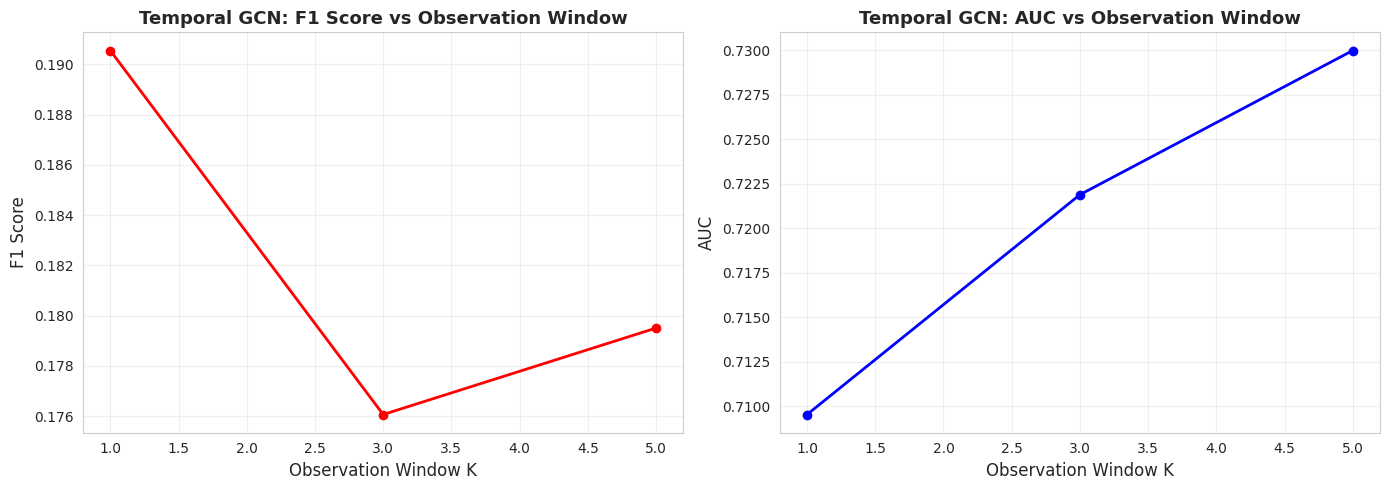

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score
ax = axes[0]
f1_scores = [results[K]['test']['f1'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], f1_scores, marker='o', linewidth=2, color='red')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Temporal GCN: F1 Score vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
auc_scores = [results[K]['test']['auc'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], auc_scores, marker='o', linewidth=2, color='blue')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('Temporal GCN: AUC vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [18]:
import os

os.makedirs('../../results', exist_ok=True)
os.makedirs('../../models', exist_ok=True)

comparison_df.to_csv('../../results/temporal_gcn_results.csv', index=False)
print("Results saved to ../../results/temporal_gcn_results.csv")

for K, model in models.items():
    torch.save(model.state_dict(), f'../../models/temporal_gcn_k{K}.pt')
print(f"Models saved to ../../models/temporal_gcn_k*.pt")

Results saved to ../../results/temporal_gcn_results.csv
Models saved to ../../models/temporal_gcn_k*.pt
